In [41]:
import geopandas
import shapely
import numpy
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))

In [194]:
aligned = geopandas.read_file(r"C:\Users\pearsonra\Documents\data\river_bathemetry\waikanae_new_lidar\caches\100000000\aligned_channel_100000000.geojson")

## Extended line offshore from the aligned line

In [195]:
t = geopandas.read_file(r"C:\Users\pearsonra\Documents\data\river_bathemetry\waikanae_new_lidar\caches\100000000\final_transect_values.geojson")

In [210]:
t.geometry

0      LINESTRING (1769079.252 5473397.316, 1769110.2...
1      LINESTRING (1769089.090 5473394.495, 1769122.7...
2      LINESTRING (1769095.356 5473392.303, 1769134.4...
3      LINESTRING (1769100.760 5473390.081, 1769145.4...
4      LINESTRING (1769105.398 5473387.862, 1769155.6...
                             ...                        
971    LINESTRING (1774324.705 5469923.734, 1774370.2...
972    LINESTRING (1774348.001 5469914.825, 1774380.4...
973    LINESTRING (1774372.026 5469908.851, 1774392.1...
974    LINESTRING (1774396.377 5469905.571, 1774405.2...
975    LINESTRING (1774416.111 5469904.628, 1774420.0...
Name: geometry, Length: 976, dtype: geometry

In [204]:
(x,y) = aligned.loc[0].geometry.xy
mouth_point = shapely.geometry.Point([x[0], y[0]])
segment_dx = x[0] - x[1]
segment_dy = y[0] - y[1]
segment_length = numpy.sqrt(segment_dx**2 + segment_dy**2)
tangen_dx = segment_dx / segment_length
tangen_dy = segment_dy / segment_length

In [206]:
length = 1000
extended_line = shapely.geometry.LineString([mouth_point, [mouth_point.x + length * tangen_dx, mouth_point.y + length * tangen_dy]])

<AxesSubplot:>

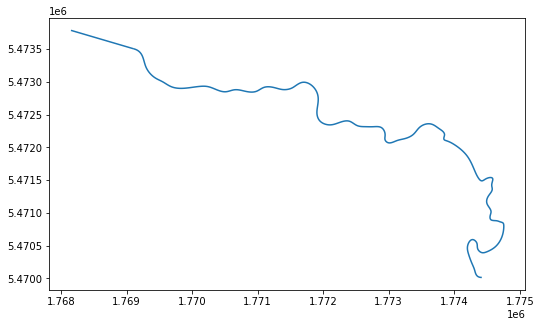

In [150]:
import matplotlib
f, ax = matplotlib.pyplot.subplots(figsize=(10, 5))
aligned.append(geopandas.GeoDataFrame(geometry=[extended_line], crs=aligned.crs)).plot(ax=ax)

## River depths and widths, and ocean depths to specify fan dimensions

Record only the depth and width at the river mouth

In [151]:
river_mouth_depth = geopandas.read_file(r"C:\Users\pearsonra\Documents\data\river_bathemetry\waikanae_new_lidar\caches\100000000\river_bathymetry_all_widths.geojson")['bed_elevation_Smart_et_al'].iloc[0]
river_mouth_width = geopandas.read_file(r"C:\Users\pearsonra\Documents\data\river_bathemetry\waikanae_new_lidar\caches\100000000\final_values.geojson")['widths'].iloc[0]

Take the smallest contours that are more than twice the depth of the river mouth

In [179]:
ocean_contours = geopandas.read_file(r"C:\Users\pearsonra\Documents\data\Waikanae\caches\nz21_kapiti\50849\bathymetry_contours.zip")
end_depth = ocean_contours['valdco'][ocean_contours['valdco'] > 2 * river_mouth_depth * -1 ].min()
ocean_contours = ocean_contours[ocean_contours['valdco'] == end_depth].reset_index(drop=True)

Find the first of these contours to intersect with the extended river line

In [154]:
distance = numpy.inf
end_point = shapely.geometry.Point()

for i, row in ocean_contours.iterrows():
    if row.geometry.intersects(extended_line):
        intersection_point = row.geometry.intersection(extended_line)
        if intersection_point.distance(aligned.iloc[0].geometry) < distance:
            distance = intersection_point.distance(mouth_point)
            end_point = intersection_point
    

### Fan polygon
Define a fan polygon with initial width of the mouth width measurements increasing in width by x degree on each side. 

In [169]:
fan_angle = 15
end_width = river_mouth_width + 2 * distance * numpy.tan(numpy.pi/180 * fan_angle)

In [156]:
fan_line = shapely.geometry.LineString([mouth_point, end_point])

In [165]:
# Calculate line slope
length = numpy.sqrt((end_point.x - mouth_point.x) ** 2 + (end_point.y - mouth_point.y) ** 2)
dx = (end_point.x - mouth_point.x) / length
dy = (end_point.y - mouth_point.y) / length
        
# Calculate line normal
normal_x = -dy
normal_y = dx

In [176]:
fan_polygon = shapely.geometry.Polygon([[mouth_point.x - normal_x * river_mouth_width / 2, mouth_point.y - normal_y * river_mouth_width / 2], 
                                        [mouth_point.x + normal_x * river_mouth_width / 2, mouth_point.y + normal_y * river_mouth_width / 2],
                                        [end_point.x + normal_x * end_width / 2, end_point.y + normal_y * end_width / 2],
                                        [end_point.x - normal_x * end_width / 2, end_point.y - normal_y * end_width / 2]])

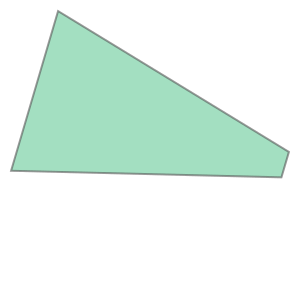

In [199]:
fan_polygon

### Fan depths
Define the depths within the centre of the fan

In [189]:
fan_depths = {'geometry': [], 'depths': []}

spacing = 10
number_of_samples = int(distance / spacing)
depth_increment = (-1 * end_depth - river_mouth_depth) / number_of_samples

for i in range(1, number_of_samples):
    fan_depths['geometry'].append(shapely.geometry.Point([mouth_point.x + dx * i * spacing, mouth_point.y + dy * i * spacing]))
    fan_depths['depths'].append(river_mouth_depth + i * depth_increment)

In [191]:
fan_depths = geopandas.GeoDataFrame(fan_depths, crs=2193)

<AxesSubplot:>

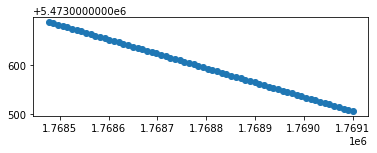

In [192]:
fan_depths.plot()